In [1]:
""" Creating a tool for stock market analysis"""

import yfinance as yf

In [2]:
%matplotlib inline

import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
#from lightgbm import LGBMRegressor
from decimal import ROUND_HALF_UP, Decimal
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import combinations, product
from functools import partial
from multiprocessing import Pool, Manager, cpu_count
from IPython.display import display_html
sns.set_context("notebook")
from my_func import ds_func
import warnings
warnings.filterwarnings("ignore")

In [3]:
ds=ds_func()

In [4]:
init_notebook_mode(connected=True)
temp = dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), width=800))
colors=px.colors.qualitative.Plotly

In [5]:
### load one ticker

In [5]:
ticker_name="AAPL"
stock_data = yf.Ticker(ticker_name)
stock_data = stock_data.history(period = '1y')
# stock_data.reset_index(inplace=True)

- AAPL: No data found for this date range, symbol may be delisted


In [6]:
tickers =['FNF', 'ASML', 'GOOGL', 'CVS']
data = yf.download(tickers, group_by="ticker", period='1y')

[*********************100%***********************]  4 of 4 completed

4 Failed downloads:
- ASML: No data found for this date range, symbol may be delisted
- CVS: No data found for this date range, symbol may be delisted
- GOOGL: No data found for this date range, symbol may be delisted
- FNF: No data found for this date range, symbol may be delisted


In [9]:
shift_period=2
stock_data['Target']=stock_data['Close'].pct_change(periods=shift_period).shift(-shift_period)
    

In [10]:
train = stock_data[stock_data['Date']>'2019-06-21']
test = stock_data[stock_data['Date']>='2019-06-21']

In [11]:
train_date=train.Date.unique()
returns=train.groupby('Date')['Target'].mean().mul(100).rename('Average Return')
close_avg=train.groupby('Date')['Close'].mean().rename('Closing Price')
vol_avg=train.groupby('Date')['Volume'].mean().rename('Volume')

fig = make_subplots(rows=3, cols=1, 
                    shared_xaxes=True)
for i, j in enumerate([returns, close_avg, vol_avg]):
    fig.add_trace(go.Scatter(x=train_date, y=j, mode='lines',
                             name=j.name, marker_color=colors[i]), row=i+1, col=1)
fig.update_xaxes(rangeslider_visible=False,
                 rangeselector=dict(
                     buttons=list([
                         dict(count=6, label="6m", step="month", stepmode="backward"),
                         dict(count=1, label="1y", step="year", stepmode="backward"),
                         dict(count=2, label="2y", step="year", stepmode="backward"),
                         dict(step="all")])),
                 row=1,col=1)
fig.update_layout(template=temp,title='Stock Market Average Stock Return, Closing Price, and Shares Traded', 
                  hovermode='x unified', height=700, 
                  yaxis1=dict(title='Stock Return', ticksuffix='%'), 
                  yaxis2_title='Closing Price', yaxis3_title='Shares Traded',
                  showlegend=False)
fig.show()

In [12]:
train_df=stock_data[stock_data.Date>'2020-12-23']
print("New Train Shape {}.\nMissing values in Target = {}".format(train_df.shape,train_df['Target'].isna().sum()))

New Train Shape (0, 8).
Missing values in Target = 0


In [13]:
fig = go.Figure()
x_hist=train_df['Target']
fig.add_trace(go.Histogram(x=x_hist*100,
                           marker=dict(color=colors[0], opacity=0.7, 
                                       line=dict(width=1, color=colors[0])),
                           xbins=dict(start=-40,end=40,size=1)))
fig.update_layout(template=temp,title='Target Distribution', 
                  xaxis=dict(title='Stock Return',ticksuffix='%'), height=450)
fig.show()

In [20]:

def prep_prices(price):
    
    from decimal import ROUND_HALF_UP, Decimal
    
    pcols = ["Open","High","Low","Close"]

    #price.ExpectedDividend.fillna(0,inplace=True)
    
    def qround(x):
        return float(Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP))
    
    def adjust_prices(df):
        df = df.sort_values("Date", ascending=False)
        df.loc[:, "CumAdjust"] = df["AdjustmentFactor"].cumprod()

        # generate adjusted prices
        for p in pcols:     
            df.loc[:, p] = (df["CumAdjust"] * df[p]).apply(qround)
        df.loc[:, "Volume"] = df["Volume"] / df["CumAdjust"]
        df.ffill(inplace=True)
        df.bfill(inplace=True)
        
        # generate and fill Targets
        #df.loc[:, "Target"] = df.Close.pct_change().shift(-2).fillna(df.Target).fillna(0)
        df.Target.fillna(0,inplace=True)

        return df

    # generate Adjusted
#     price = price.sort_values(["SecuritiesCode", "Date"])
#     price = price.groupby("SecuritiesCode").apply(adjust_prices).reset_index(drop=True)
#     price = price.sort_values("RowId")
    return price

In [21]:
df_train = stock_data[(stock_data.Date>"2020-10-02")&(stock_data.Date <"2021-10-02")] #Targets not Nulls and 2000 secutities data
df_train = prep_prices(df_train)

df_test = stock_data[(stock_data.Date>="2021-10-02")]
df_test = prep_prices(df_test)

In [22]:

cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target']
STOCK = df_train[cols].set_index("Date")
TEST = df_test.set_index("Date")
display_html(STOCK)

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2020-10-05,977.372486,1012.750132,977.372486,1006.797791,14212509,0.522732
2020-10-06,1012.846007,1017.646225,990.140953,1013.566040,9090819,0.529741
2020-10-07,1003.149662,1029.166823,994.125228,1023.934631,9284008,0.494709
2020-10-08,1046.447519,1079.089002,1044.911473,1049.999634,21482613,0.464517
2020-10-09,1051.343593,1068.816455,1044.959280,1062.576172,10567867,0.457475
...,...,...,...,...,...,...
2021-09-27,1734.839613,1735.084820,1685.160648,1688.152222,5045337,-0.141132
2021-09-28,1677.215992,1677.215992,1642.887009,1654.755005,6557197,-0.131442
2021-09-29,1627.438949,1668.780875,1623.270429,1659.806274,7792548,-0.124928


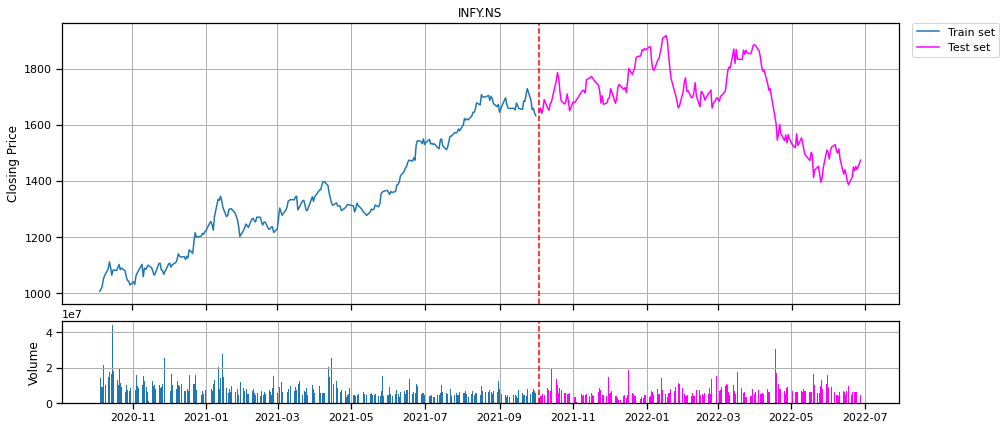

In [23]:
plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
top.plot(STOCK.index, STOCK.Close, label="Train set")
top.plot(TEST.index,TEST.Close, color="magenta", label="Test set")
bottom.bar(STOCK.index, STOCK.Volume)
bottom.bar(TEST.index, TEST.Volume, color="magenta")
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
 
# set the labels
top.axes.xaxis.set_ticklabels([])
top.axvline(TEST.index[0], color='red', linestyle='--')
bottom.axvline(TEST.index[0], color='red', linestyle='--')
top.set_title(ticker_name)
top.grid(True)
top.set_ylabel('Closing Price')
bottom.set_ylabel('Volume')
bottom.grid(True);

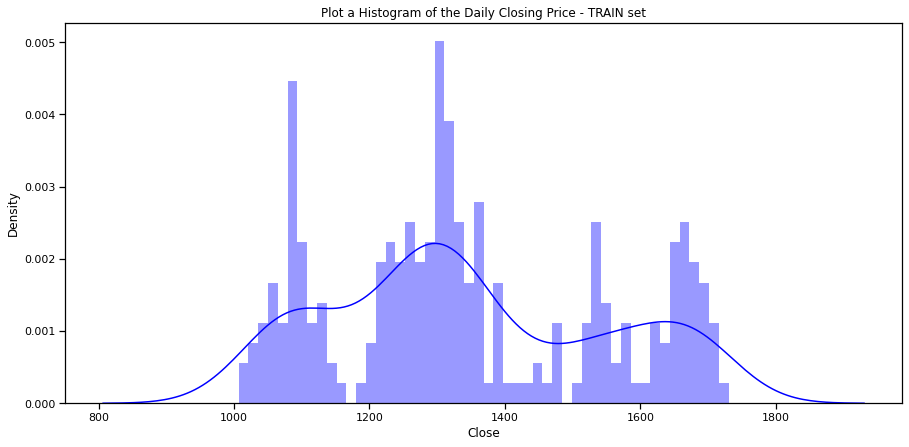

In [24]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TRAIN set")
sns.distplot(STOCK['Close'].dropna(), bins=50, color='blue');

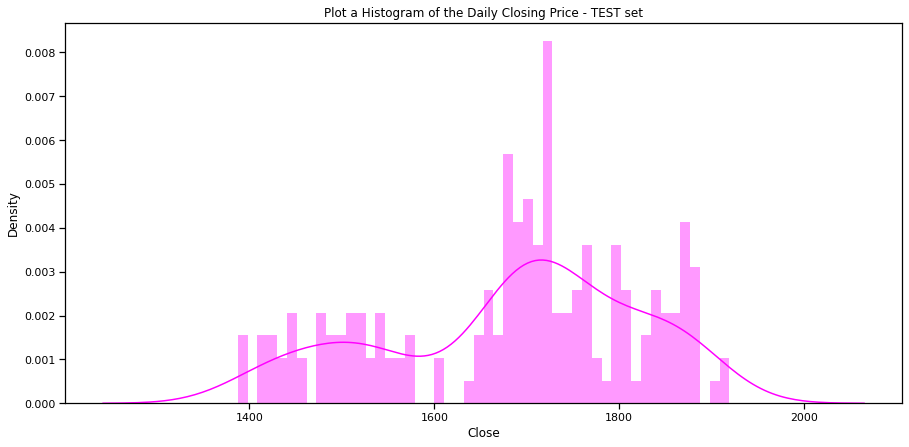

In [25]:
plt.figure(figsize=(15,7))
plt.title("Plot a Histogram of the Daily Closing Price - TEST set")
sns.distplot(TEST['Close'].dropna(), bins=50, color='magenta');

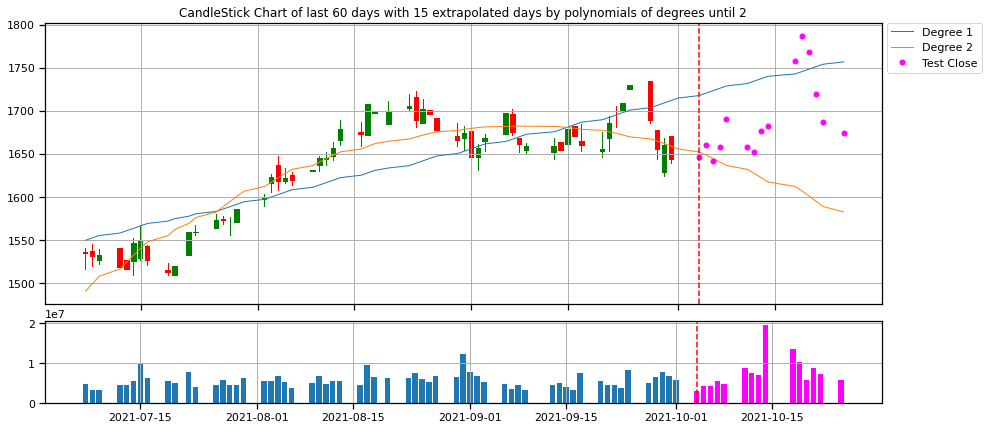

In [26]:
d = 60 # days to plot
e = 15  # days to extrapolate
g = 2  # max degree of regression

width = .8
width2 = .1
col1 = 'green'
col2 = 'red'

LDAYS = STOCK.tail(d)
up = LDAYS[LDAYS.Close>=LDAYS.Open]
down = LDAYS[LDAYS.Close<LDAYS.Open]
fut = TEST[TEST.index<=TEST.head(e).index[-1]]

xd = (LDAYS.index).append(TEST.head(e).index)

x = [x for x in range(d)]
p = {}
for i in range(g):
    z = np.polyfit(x, LDAYS.Close, i+1)
    p[i] = np.poly1d(z)
x = np.array(range(d+e))

plt.figure(figsize=(15,7))
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.set_title(f"CandleStick Chart of last {d} days with {e} extrapolated days by polynomials of degrees until {g}")
top.axes.xaxis.set_ticklabels([])
for i in range(g):
    top.plot(xd, p[i](x), linewidth=1, label=f'Degree {i+1}')
top.plot(fut.index,fut.Close,  marker="o", markersize=5, color="magenta", linewidth=0, label="Test Close")
top.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
top.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
top.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)
top.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
top.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
top.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)
top.axvline(TEST.index[0], color='red', linestyle='--')
top.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
top.grid(True)

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(xd, np.append(LDAYS['Volume'].values,np.zeros(e))) 
bottom.bar(fut.index, fut.Volume, color="magenta") 
bottom.axvline(TEST.index[0], color='red', linestyle='--')

bottom.grid(True)
plt.show();

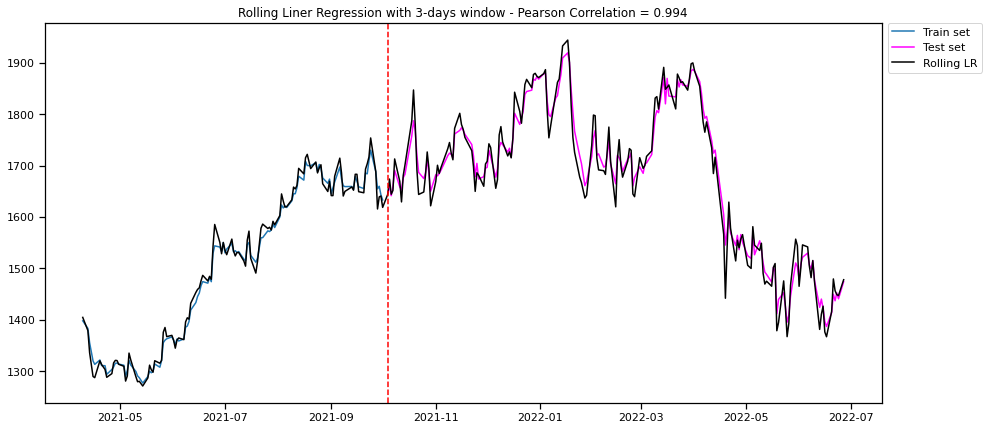

In [27]:

d = 120 # days to plot
w = 3 # windows size

LDAYS = STOCK.tail(d)
fut = pd.concat([STOCK,TEST])
xd = (LDAYS.index).append(TEST.index)

fut['Cl_lr'] = fut.Close.rolling(window=w,closed="left").apply(lambda y: 
                   np.poly1d(np.polyfit(np.array(range(w)),y,1))(w),raw=True)

fut['Cl2'] = fut.Close.rolling(window=2,closed="left").apply(lambda y: 
                   np.poly1d(np.polyfit([0,1],y,1))(2),raw=True)

rho = np.corrcoef(fut.Close[-len(xd):],fut.Cl_lr[-len(xd):])

plt.figure(figsize=(15,7))
plt.plot(LDAYS.index, LDAYS.Close, label="Train set")
plt.plot(TEST.index,TEST.Close, color="magenta", label="Test set")
plt.plot(xd,fut.Cl_lr[-len(xd):], color="black", label="Rolling LR")
plt.axvline(TEST.index[0], color='red', linestyle='--')
plt.title(f"Rolling Liner Regression with {w}-days window - Pearson Correlation = {rho[0,1]:.3f}")
plt.legend(bbox_to_anchor=(1.01, 1., 0.11, 0.), loc='upper right', borderaxespad=0.)
plt.show();

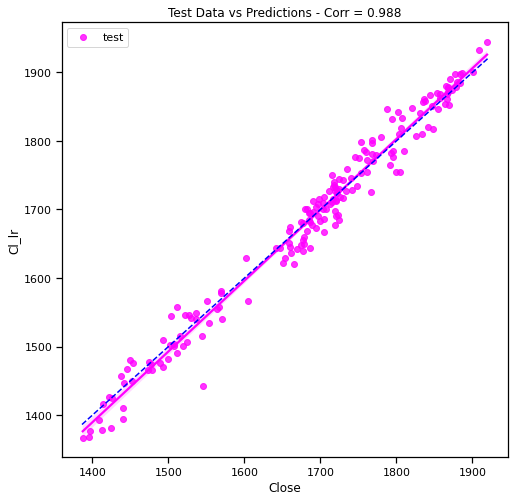

In [28]:
# Generate diagonal line to plot.
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=TEST.Close.min() - 1, stop=TEST.Close.max() + 1, num=100)
sns.regplot(x=TEST.Close, y=fut.Cl_lr[-len(TEST):], color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.set(title=f'Test Data vs Predictions - Corr = {np.corrcoef(TEST.Close,fut.Cl_lr[-len(TEST):])[0,1]:.3f}');

In [33]:
from prophet import Prophet

In [35]:

from prophet.make_holidays import make_holidays_df

year_list = [2017, 2018, 2019, 2020, 2021, 2022, 2023]
holidays = make_holidays_df(year_list=year_list, country='IN')

ph_df = fut[["Close","Cl_lr",'Cl2']][w:len(STOCK)].reset_index()
ph_df.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

m = Prophet(holidays=holidays,
            daily_seasonality=False,
            changepoint_prior_scale=0.015)
m.add_seasonality(name='monthly', period=20.5, fourier_order=5)
m.add_regressor('Cl_lr')
m.add_regressor('Cl2')
m.fit(ph_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [37]:
TEST.shape


(182, 8)

In [38]:
# Predict Prices
future_prices = m.make_future_dataframe(periods=175, freq='d')
future_prices = future_prices[future_prices.ds.dt.dayofweek < 5]
future_prices = future_prices.set_index("ds").join(fut[['Cl_lr','Cl2']][w:], how='left')
future_prices = future_prices.reset_index().dropna()
forecast = m.predict(future_prices)
result = TEST[['Close']].join(forecast[['ds','yhat','yhat_lower','yhat_upper']].set_index("ds"),how='left')
display_html(result)

,Close,yhat,yhat_lower,yhat_upper
Date,,,,
2021-10-04,1646.565063,1661.125458,1647.839692,1672.665097
2021-10-05,1660.345825,1680.238697,1668.264442,1692.852058
2021-10-06,1641.464966,1653.032133,1639.931039,1666.123004
2021-10-07,1658.580322,1673.829094,1661.525645,1686.299279
2021-10-08,1690.800537,1726.021387,1713.260783,1738.775007
...,...,...,...,...
2022-06-21,1449.900024,NaN,NaN,NaN
2022-06-22,1437.250000,NaN,NaN,NaN
2022-06-23,1452.449951,NaN,NaN,NaN


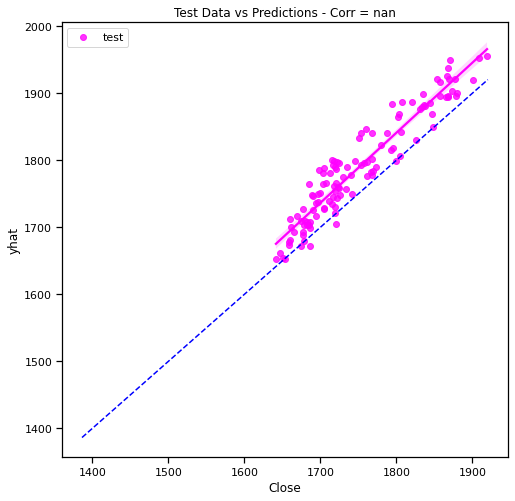

In [39]:
# Generate diagonal line to plot.
rho = np.corrcoef(result.Close,result.yhat)
fig, ax = plt.subplots(figsize=(8,8))
d_x = np.linspace(start=TEST.Close.min() - 1, stop=TEST.Close.max() + 1, num=175)
sns.regplot(x=result.Close, y=result.yhat, color='magenta', label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color='blue', ax=ax)
ax.lines[1].set_linestyle('--')
ax.legend(loc='upper left')
ax.set(title=f'Test Data vs Predictions - Corr = {np.corrcoef(result.Close,result.yhat)[0,1]:.3f}');

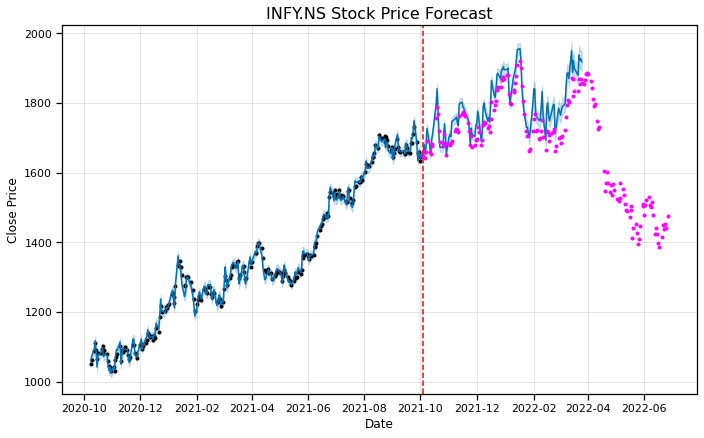

In [41]:
fig = m.plot(forecast)
plt.title(f"{ticker_name} Stock Price Forecast", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.axvline(TEST.index[0], color='red', linestyle='--')
plt.plot(TEST.index, TEST.Close,  marker="o", markersize=3, color="magenta", linewidth=0, label="Test Close")
plt.show()

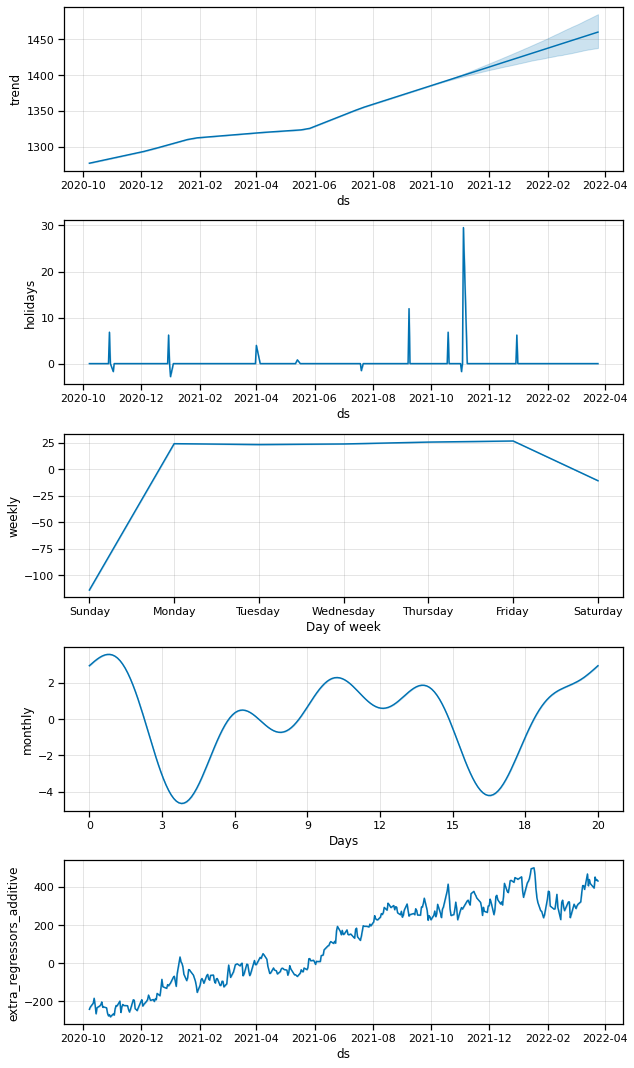

In [42]:
fig2 = m.plot_components(forecast)
plt.show()